## REQUIREMENTS

### This notebook is configured to load files from *metadata* and *data* folders. A small sample of INSTANCE data can be downloaded from http://repo.pi.ingv.it/instance/Instance_sample_dataset.tar.bz2. The downloaded file should be untarred in the *instance* directory cloned from GitHub.

### The collection of plots of this notebook is meant to be an overview of the characteristics of the metadata of INSTANCE.

Please note that the plots generated below adopt a very small subset of data and metadata randomly sampled from the whole dataset.

Last update: 2022/07/26

# **How to plot multiple waveforms in a single picture**

### This notebook provides some example to select waveform data according to the metadata provided. 

This has been used to generate figures 14, 15, 16 and 20 of the article:
Michelini A., Cianetti S., Gaviano S, Giunchi C., Jozinovic D. and V. Lauciani, INSTANCE - The Italian seismic dataset for machine learning, submitted to Earth System Science Data, 2021.  
This notebook specializes to plot P-wave onsets.

In [1]:
import string
import argparse as ap
import sys
import os
import numpy as np

import obspy
import obspy.core as oc
from obspy import read_inventory

# from datetime import datetime, timedelta
import time

import pylab as plt
import pandas as pd
import h5py


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import datetime
import warnings

mpl.rcParams['pdf.fonttype'] = 42

## Define the path to metadata and hdf5 files

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# directory PATH
METADIR = '../metadata'
HDFDIR = '../data'
FIGDIR='../output'

# file NAMES
# MetaData
events_metaname=os.path.join(METADIR,'metadata_Instance_events_10k.csv') # Either Counts and GroundMotion
noise_metaname=os.path.join(METADIR,'metadata_Instance_noise_1k.csv')
# HDF5
events_hdfname=os.path.join(HDFDIR,'Instance_events_counts_10k.hdf5')
gm_hdfname=os.path.join(HDFDIR,'Instance_events_gm_10k.hdf5')
noise_hdfname=os.path.join(HDFDIR,'Instance_noise_1k.hdf5')
# Figures
# events_figname=os.path.join(FIGDIR,'waveforms_Evs.png')
# gm_figname=os.path.join(FIGDIR,'waveforms_Evs_gm.png')
# noise_figname=os.path.join(FIGDIR,'waveforms_Noise.png')

## Read metadata for events and noise

In [4]:
events_metaData = pd.read_csv(events_metaname, keep_default_na=False, dtype={'station_location_code': object, 
           'source_mt_eval_mode':object,'source_mt_status': object,'source_mechanism_strike_dip_rake': object, 
           'source_mechanism_moment_tensor': object, 'trace_p_arrival_time': object, 'trace_s_arrival_time': object},
                             low_memory=False)

In [5]:
noise_metaData = pd.read_csv(noise_metaname,dtype={'station_location_code': object}, low_memory=False)

## You can also read bz2 directly

In [6]:
# events_metaname_bz2 = os.path.join(METADIR,'events.csv.bz2')
# events_metaData = pd.read_csv(events_metaname_bz2, keep_default_na=False, dtype={'station_location_code': object, 
#            'source_mt_eval_mode':object,'source_mt_status': object,'source_mechanism_strike_dip_rake': object, 
#            'source_mechanism_moment_tensor': object, 'trace_p_arrival_time': object, 'trace_s_arrival_time': object})

## Read Waveforms hdf5 files

In [12]:
events_h5File = h5py.File(events_hdfname, 'r') # Events in counts
gm_h5File = h5py.File(gm_hdfname, 'r')         # Events in ground motion units
# noise_h5File = h5py.File(noise_hdfname, 'r')   # Noise in counts

## Load plot function

In [13]:
sys.path.append('./Def_plot_waveform.py')

In [14]:
from Def_plot_waveform import split, build_stream, multiple_streams, multiple_streams_zoom
# from Def_plot_waveform import split, build_stream, multiple_streams

## Figure labels

In [15]:
fignumbers = 'abcdefghijklmnopqrstuvwxyz'
alllabs = split(fignumbers)

## Here is the list of available metadata for events

In [16]:
events_metaData.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 115 columns):
 #    Column                            Non-Null Count  Dtype  
---   ------                            --------------  -----  
 0    source_id                         10000 non-null  int64  
 1    station_network_code              10000 non-null  object 
 2    station_code                      10000 non-null  object 
 3    station_location_code             10000 non-null  object 
 4    station_channels                  10000 non-null  object 
 5    station_latitude_deg              10000 non-null  float64
 6    station_longitude_deg             10000 non-null  float64
 7    station_elevation_m               10000 non-null  float64
 8    station_vs_30_mps                 10000 non-null  float64
 9    station_vs_30_detail              10000 non-null  object 
 10   source_origin_time                10000 non-null  object 
 11   source_latitude_deg               10000 non-null  flo

## Convert argument of metadata columns with different type to numeric.

In [17]:
list_eve=['trace_E_min_counts','trace_N_min_counts','trace_Z_min_counts',
         'trace_E_max_counts','trace_N_max_counts','trace_Z_max_counts',
         'trace_E_median_counts','trace_N_median_counts','trace_Z_median_counts',
         'trace_E_mean_counts','trace_N_mean_counts','trace_Z_mean_counts',
         'trace_E_pga_perc','trace_N_pga_perc','trace_Z_pga_perc',
         'trace_E_pga_cmps2','trace_N_pga_cmps2','trace_Z_pga_cmps2',
         'trace_E_pgv_cmps','trace_N_pgv_cmps','trace_Z_pgv_cmps',
         'trace_E_snr_db','trace_N_snr_db','trace_Z_snr_db',
         'trace_E_sa03_cmps2','trace_N_sa03_cmps2','trace_Z_sa03_cmps2',
         'trace_pgv_cmps', 'trace_pga_perc',
         'trace_EQT_number_detections','trace_EQT_P_number','trace_EQT_S_number','trace_GPD_P_number','trace_GPD_S_number']

list_noise=['trace_E_max_counts','trace_EQT_number_detections','trace_GPD_P_number','trace_GPD_S_number']

In [18]:
for ele in list_eve:
    events_metaData[ele] =  pd.to_numeric(events_metaData[ele], errors='coerce')
for ele in list_noise:
    noise_metaData[ele] =  pd.to_numeric(noise_metaData[ele], errors='coerce')

# Select waveforms randomy to verify polarities
Example  of  randomly  selected  earthquake  waveforms  of  the  broadband  HH  channels  contained  in  INSTANCE.  Each  row contains three randomly selected traces drawn according to the following criteria: (a-i) earthquakes with P-onset positive polarities; (j-r) earthquakes with P-onset negative polarities; The arrival times of P- and S-wave onsets are shown by blue and redvertical lines, respectively

In [19]:
cha = 'HH'

In [20]:
# TOTAL = events_metaData.shape[0]
TOTAL = events_metaData.loc[events_metaData.station_channels == cha].shape[0]
TOTAL

3893

In [28]:
chosen_lines = []
plots_line = 2

### select different random number initializations

In [29]:
random_state = 7

In [30]:
#events_metaData['trace_polarity'].head()

#### 1) select earthquakes with  `trace_polarity` ==  `positive` and `station_channels` = 'HH'

In [31]:
polarity = 'positive'

###### first row

In [32]:
df_tmp = events_metaData.loc[(events_metaData.trace_polarity == polarity) &
                             (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=random_state).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

N records:  703 % total:  18.058052915489338


###### second row

In [33]:
df_tmp = events_metaData.loc[(events_metaData.trace_polarity == polarity) &
                             (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=random_state+1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

N records:  703 % total:  18.058052915489338


###### third row

In [34]:
df_tmp = events_metaData.loc[(events_metaData.trace_polarity == polarity) &
                             (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=random_state+2).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

N records:  703 % total:  18.058052915489338


#### 2) select earthquakes with  `trace_polarity` ==  `negative` and `station_channels` = 'HH'

In [35]:
polarity = 'negative'

###### fourth row

In [36]:
df_tmp = events_metaData.loc[(events_metaData.trace_polarity == polarity) &
                             (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=random_state).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

N records:  374 % total:  9.606986899563319


###### fifth row

In [37]:
df_tmp = events_metaData.loc[(events_metaData.trace_polarity == polarity) &
                             (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=random_state+1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

N records:  374 % total:  9.606986899563319


###### sixth row

In [38]:
df_tmp = events_metaData.loc[(events_metaData.trace_polarity == polarity) &
                             (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=random_state+2).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

N records:  374 % total:  9.606986899563319


## Plot waveforms in Counts

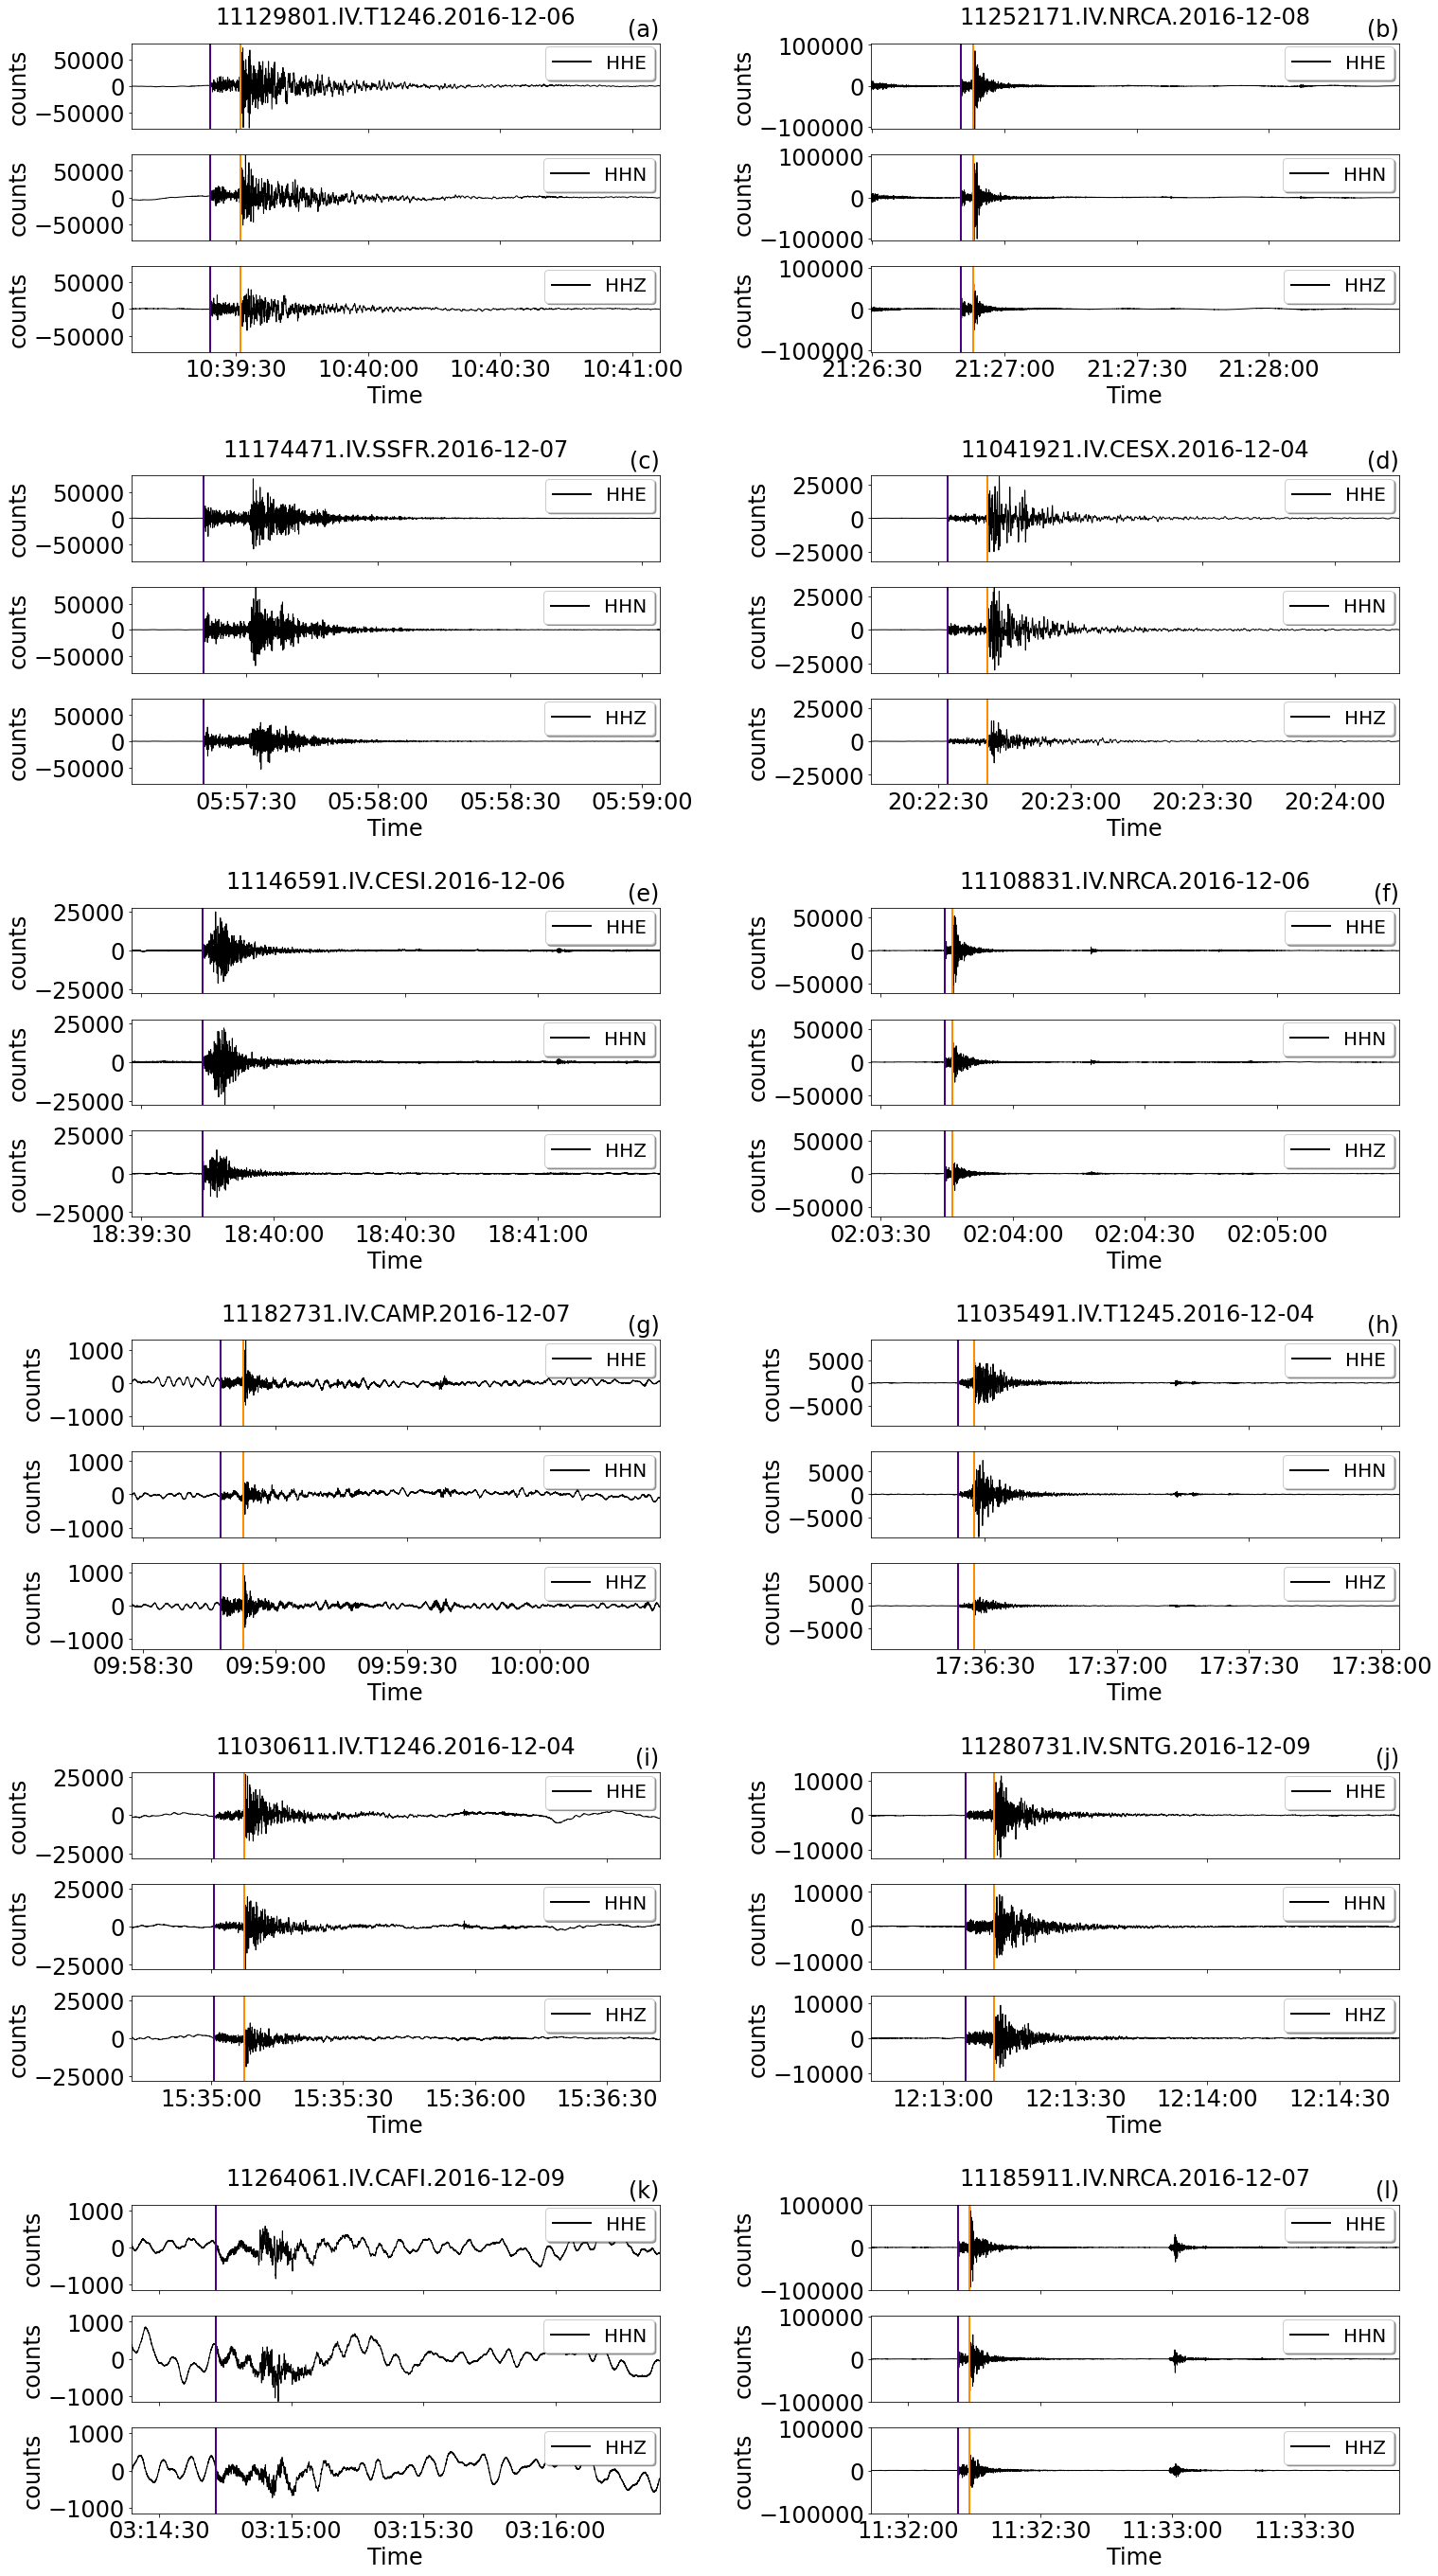

In [39]:
lines = chosen_lines
# Kind of unit
units = len(lines)*["counts"]

# Do you want the traces filtered?
filt = False
freq_min=3.0
freq_max=20.0

nrow=int(len(lines)/plots_line)
ncol=plots_line

labs = alllabs[:(ncol*nrow)]

wftype='ev_c'
if wftype == 'ev_c':
    df = events_metaData
    h5 = events_h5File
elif wftype == 'ev_gm':
    df = events_metaData
    h5 = gm_h5File
elif wftype == 'noise':
    df = noise_metaData
    h5 = noise_h5File

multiple_streams(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)
gm_figname=os.path.join(FIGDIR,'polarities_' + str(random_state) + '.png')
plt.savefig(gm_figname,dpi=300)



## Plot the same traces centered to the P-onset time

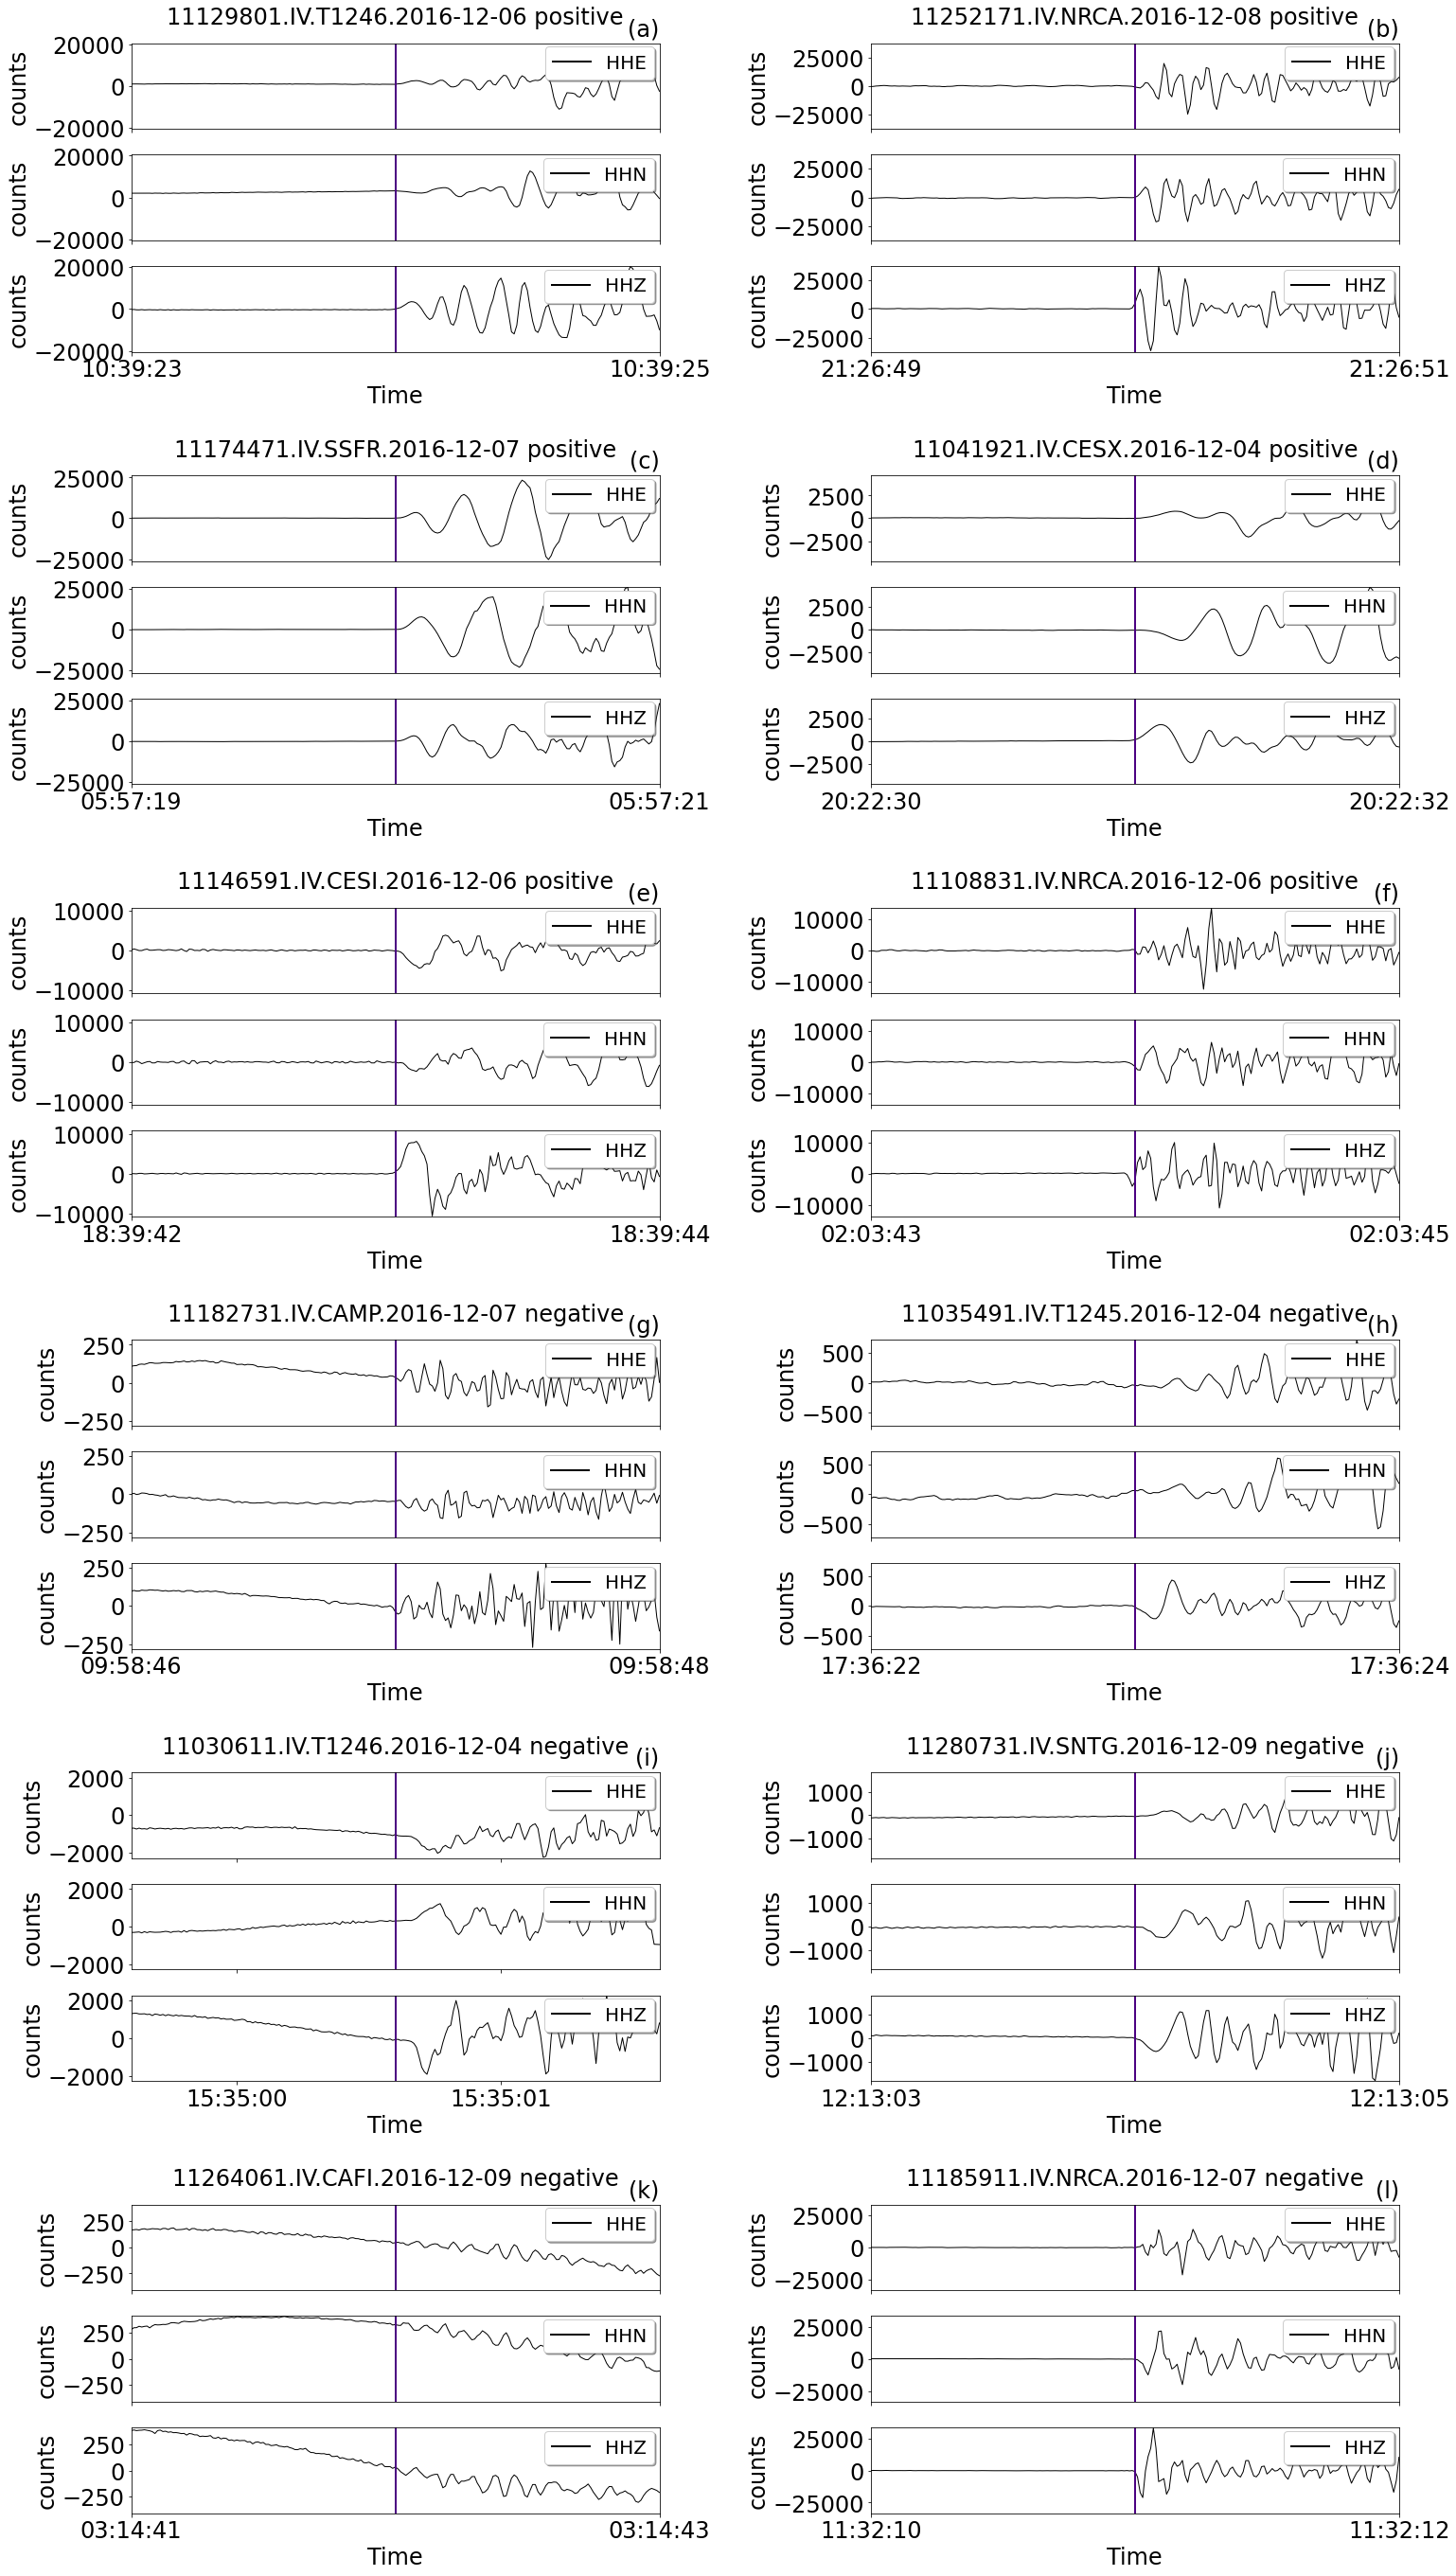

In [40]:
lines = chosen_lines
# Kind of unit
units = len(lines)*["counts"]

# Do you want the traces filtered?
filt = False
freq_min=3.0
freq_max=20.0
#
dt = 1.0

nrow=int(len(lines)/plots_line)
ncol=plots_line

labs = alllabs[:(ncol*nrow)]

wftype='ev_c'
if wftype == 'ev_c':
    df = events_metaData
    h5 = events_h5File
elif wftype == 'ev_gm':
    df = events_metaData
    h5 = gm_h5File
elif wftype == 'noise':
    df = noise_metaData
    h5 = noise_h5File

multiple_streams_zoom(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max,dt)
gm_figname=os.path.join(FIGDIR,'polarities_zoom_'+ str(random_state) + '.png')
plt.savefig(gm_figname,dpi=300)



# plot the Amoruso set of traces

### read the selected traces

In [41]:
AUXDIR='../aux'
# MetaData
amoruso_list=os.path.join(AUXDIR,'lista_amoroso.csv') 

In [42]:
df_amor = pd.read_csv(amoruso_list)

In [43]:
df_amor

,source_id,station_network_code,station_code,station_channels
0,11054551,IV,T1241,EH
1,11071881,IV,MMO1,EH
2,11062411,IV,RAFF,HH
3,11069371,IV,SNTG,HH
4,11072441,IV,CAMP,HH
5,11072811,IV,SNTG,HH
6,11108831,IV,NRCA,HH
7,11108831,IV,GUMA,HH
8,11111951,IV,NRCA,HH
9,11111951,IV,MMO1,EH


In [45]:
chosen_lines = []
plots_line = 2

In [46]:
for index, row in df_amor.iterrows():
    
    df_tmp = events_metaData.loc[(events_metaData.source_id == row['source_id']) &
                             (events_metaData.station_code == row['station_code']) &
                             (events_metaData.station_channels == row['station_channels'])]
    print (df_tmp.index.to_numpy()[0], row['source_id'], row['station_code'], row['station_channels'], df_tmp['trace_polarity'])

    #print(row['source_id'], row['station_code'], row['station_channels'])

    chosen_lines.append(df_tmp.index.to_numpy()[0])


1196 11054551 T1241 EH 1196    positive
Name: trace_polarity, dtype: object
1671 11071881 MMO1 EH 1671    positive
Name: trace_polarity, dtype: object
1383 11062411 RAFF HH 1383    positive
Name: trace_polarity, dtype: object
1532 11069371 SNTG HH 1532    negative
Name: trace_polarity, dtype: object
1716 11072441 CAMP HH 1716    positive
Name: trace_polarity, dtype: object
1752 11072811 SNTG HH 1752    positive
Name: trace_polarity, dtype: object
2687 11108831 NRCA HH 2687    positive
Name: trace_polarity, dtype: object
2682 11108831 GUMA HH 2682    negative
Name: trace_polarity, dtype: object
2913 11111951 NRCA HH 2913    positive
Name: trace_polarity, dtype: object
2911 11111951 MMO1 EH 2911    positive
Name: trace_polarity, dtype: object
3460 11125821 T1245 HH 3460    negative
Name: trace_polarity, dtype: object
2937 11111951 T1243 HH 2937    negative
Name: trace_polarity, dtype: object
3594 11129801 CAFI HH 3594    positive
Name: trace_polarity, dtype: object
4902 11163921 T1243 HH

In [47]:
len(chosen_lines)

14

In [48]:
#chosen_lines = chosen_lines[:12]

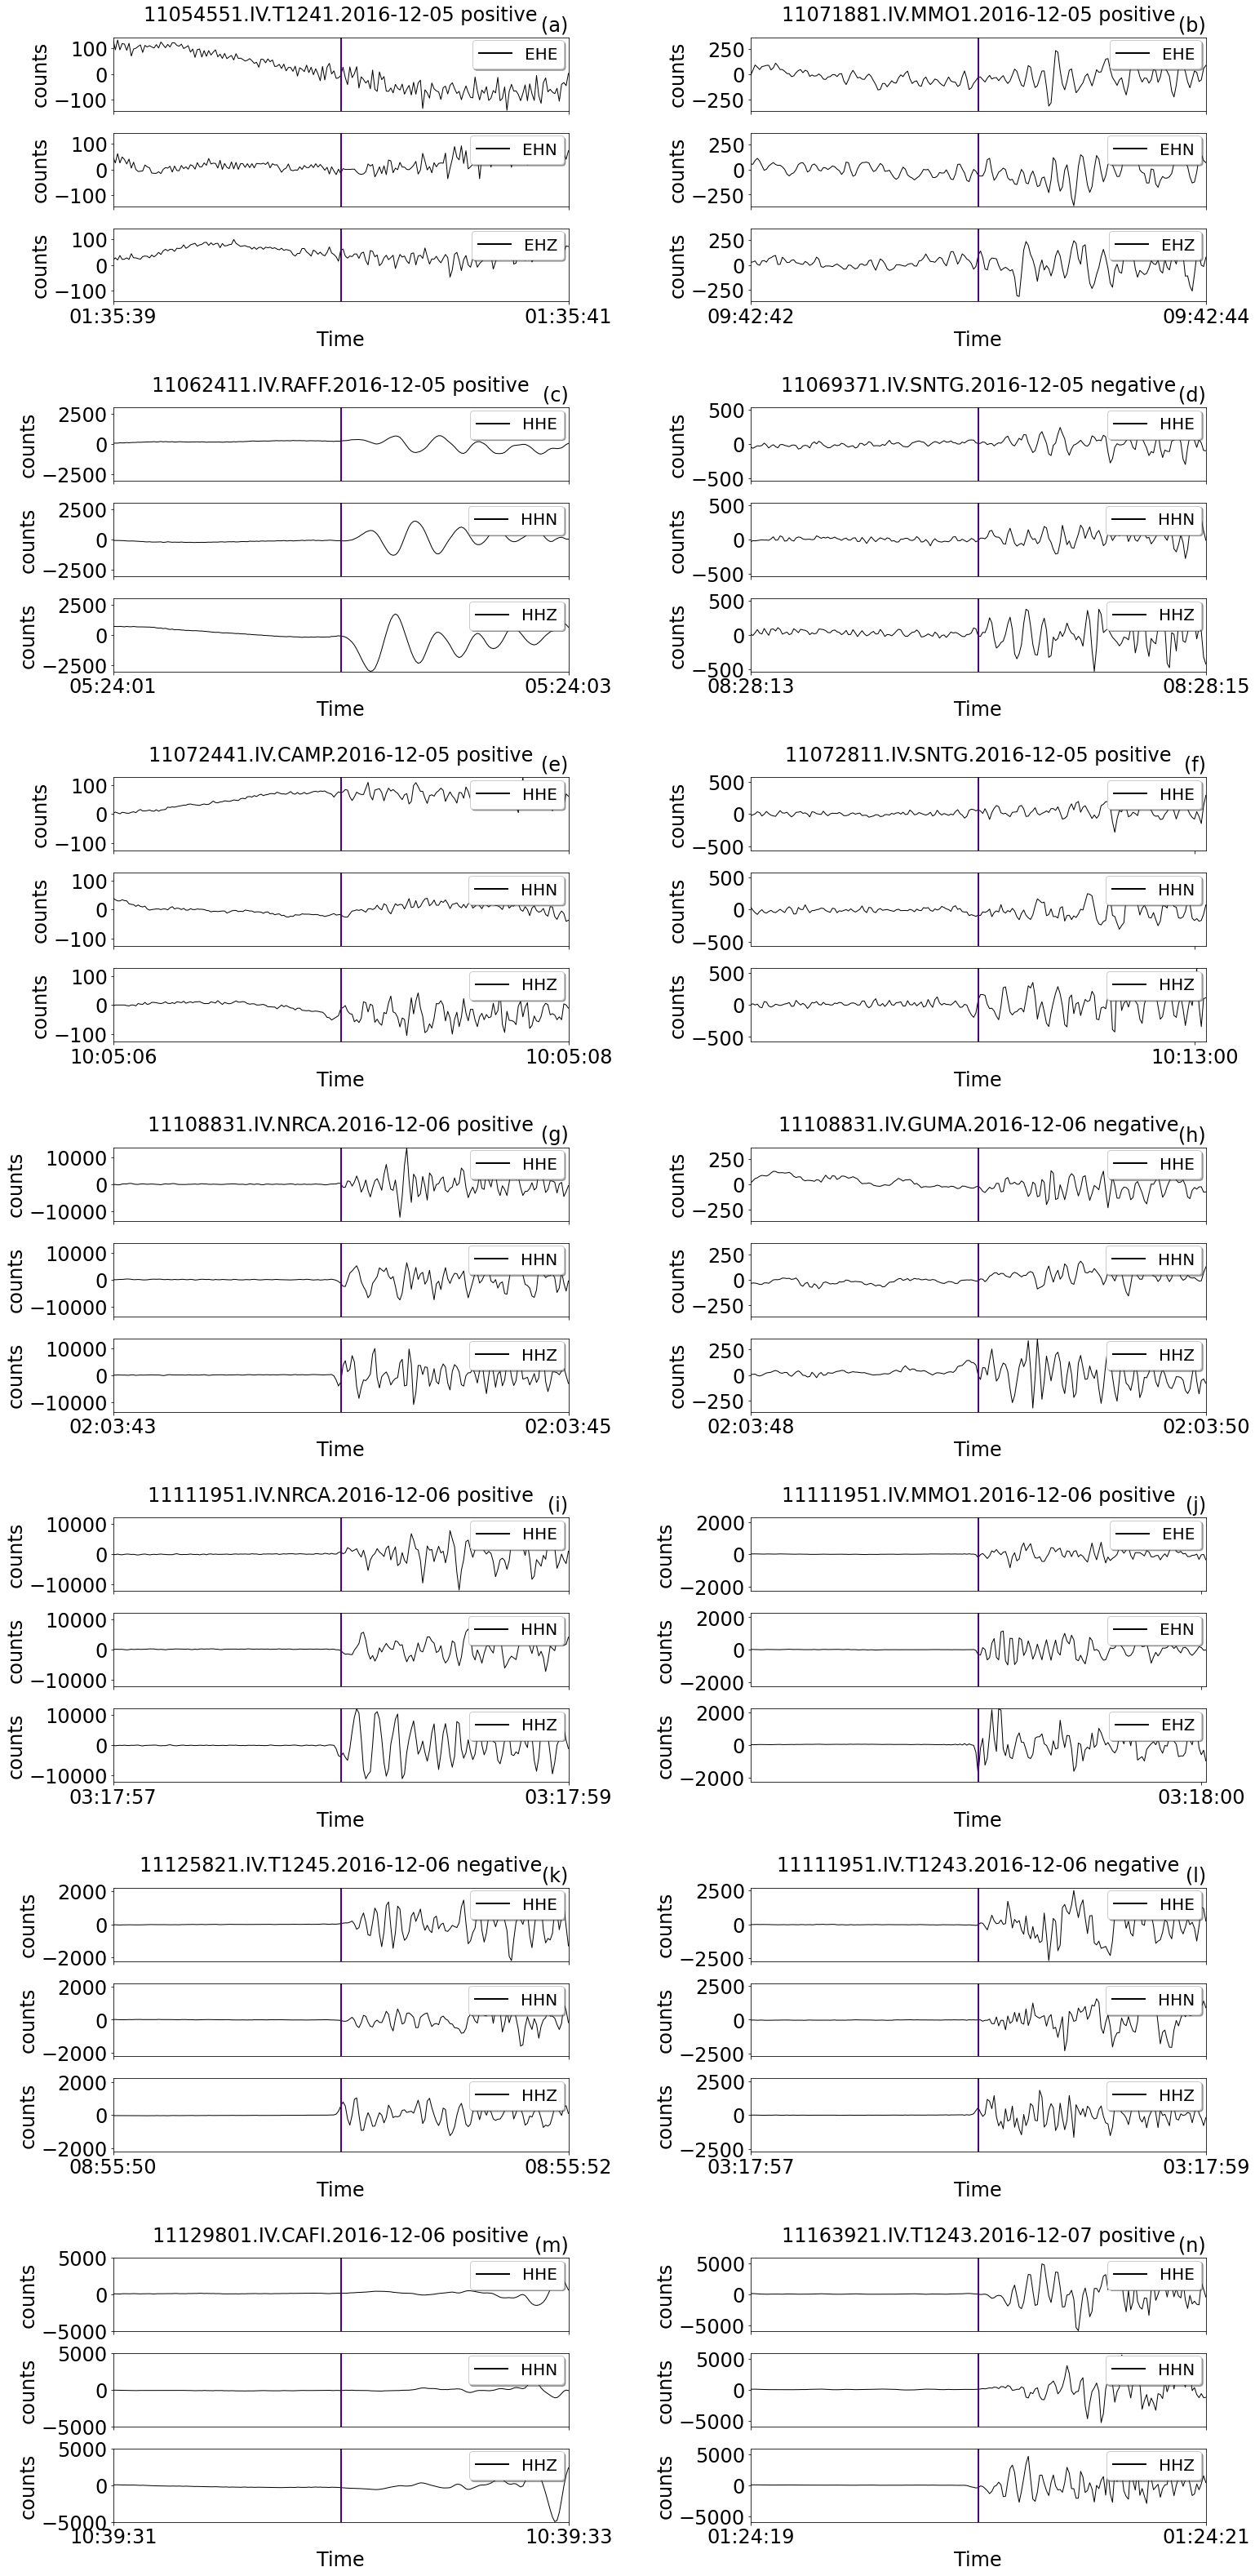

In [49]:
lines = chosen_lines
# Kind of unit
units = len(lines)*["counts"]

# Do you want the traces filtered?
filt = False
freq_min=3.0
freq_max=20.0
#
dt = 1.0

nrow=int(len(lines)/plots_line)
ncol=plots_line

labs = alllabs[:(ncol*nrow)]

wftype='ev_c'
if wftype == 'ev_c':
    df = events_metaData
    h5 = events_h5File
elif wftype == 'ev_gm':
    df = events_metaData
    h5 = gm_h5File
elif wftype == 'noise':
    df = noise_metaData
    h5 = noise_h5File

multiple_streams_zoom(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max,dt)
gm_figname=os.path.join(FIGDIR,'polarities_zoom_1-14_amoruso.png')
plt.savefig(gm_figname,dpi=300)

